#Project Title
Earnings-Call Language & Short‑Term Market Reaction:


An Exploratory Analysis of Management Tone & Post-Announcement Stock Returns

**Objective:**


To examine how the tone and linguistic style of corporate earnings calls influence short-term stock market reactions

**Goals:**

- Quantify management sentiment using NLP features such as polarity, emotional intensity, and sentence complexity.

- Analyze the relationship between sentiment measures and post-announcement returns (1-day, 3-day, 5-day, and CAR5).

- Compare sentiment–return dynamics across sectors to identify variation in market sensitivity.

- Explore which linguistic features (positive/negative word counts, uncertainty, sentence length) most strongly correlate with abnormal returns.

**Sample Size:**


This study focuses on the top 2 companies (by market cap) for 5 main sectors i.e. Technology, Communication Services, Consumer Discretionary,  Health Care, Financials

**Data Sources:**

- Constituents List: The list of S&P 500 companies was obtained from
https://datahub.io/core/s-and-p-500-companies/r/constituents.csv.
- Transcripts: `defeatbeta_api` → `Ticker(...).earning_call_transcripts()`; `content_full` concatenated per call.  
- Prices & Benchmark: `yfinance` → daily prices for tickers + SPY; compute 1/3/5‑day returns and CAR5.  
- Firm Metadata: `yfinance.info` → sector/industry and `market_cap_billion`.


# Data Collection

In [2]:
import requests
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
import yfinance as yf

Finding the top 2 companies (by market cap) from 5 main sectors through the S&P500 market data.

In [3]:
sp500_url = "https://datahub.io/core/s-and-p-500-companies/r/constituents.csv" #getting top marketcap companies from s&p500 csv file

response = requests.get(sp500_url)
print(response)                  # <Response [200]>
print(response.text[:500])       # preview first 500 chars

#read the CSV text into a DataFrame
from io import StringIO
sp500 = pd.read_csv(StringIO(response.text))
sp500.head()


<Response [200]>
Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ACN,Accenture,Information Te


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
#Rename the columns and prep tickers
sp500 = sp500.rename(columns={"Symbol": "ticker", "GICS Sector": "gics_sector"})
sp500["ticker"] = sp500["ticker"].astype(str).str.replace(".", "-", regex=False)  # BRK.B -> BRK-B for Yahoo

#Keep only these main 5 sectors
target_map = {
    "Information Technology": "Technology",
    "Communication Services": "Communication Services",
    "Consumer Discretionary": "Consumer Discretionary",
    "Health Care": "Health Care",
    "Financials": "Financials"
}

sp500 = sp500[sp500["gics_sector"].isin(target_map.keys())].copy()
sp500["chosen_sector"] = sp500["gics_sector"].map(target_map)

sp500[["ticker","gics_sector","chosen_sector"]].head()


,ticker,gics_sector,chosen_sector
2,ABT,Health Care,Health Care
3,ABBV,Health Care,Health Care
4,ACN,Information Technology,Technology
5,ADBE,Information Technology,Technology
6,AMD,Information Technology,Technology


In [5]:
#Pull market caps from Yahoo finance
rows = []
for i in range(len(sp500)):
    t = sp500.iloc[i]["ticker"]
    s = sp500.iloc[i]["chosen_sector"]
    try:
        info = yf.Ticker(t).info
        mc = info.get("marketCap", None)
    except Exception:
        mc = None
    print(t, mc)
    rows.append({"ticker": t, "chosen_sector": s, "market_cap": mc})
    time.sleep(0.05)

#Create DataFrame, remove missing market caps, and clean formatting
mktcaps = pd.DataFrame(rows).dropna(subset=["market_cap"]).copy()
mktcaps["market_cap"] = mktcaps["market_cap"].astype("int64")

#Sort by sector and descending market cap for easy comparison
mktcaps = mktcaps.sort_values(["chosen_sector","market_cap"], ascending=[True, False])
mktcaps.head()


ABT 219889582080
ABBV 403216924672
ACN 154916896768
ADBE 148234633216
AMD 381352050688
AFL 57681580032
A 41804972032
ABNB 78060044288
AKAM 10712333312
ALGN 9858146304
ALL 51328208896
GOOGL 3048500101120
GOOG 3048500101120
AMZN 2357905326080
AXP 244494106624
AIG 43683201024
AMP 45075951616
AMGN 157680812032
APH 165202837504
ADI 119687831552
AON 73604136960
APO 70387892224
AAPL 3852268208128
AMAT 182008889344
APTV 18503051264
ACGL 32641845248
ANET 191998754816
AJG 72419983360
AIZ 10676160512
T 175023587328
ADSK 65995919360
AZO 66614333440
BAC 379370864640
BAX 11808147456
BDX 53464621056
BRK-B 1056941080576
BBY 17318647808
TECH 10285108224
BIIB 22003918848
BLK 174487502848
BX 190343004160
XYZ 47888916480
BK 74637262848
BKNG 165078777856
BSX 153879904256
BMY 89213157376
AVGO 1625863094272
BRO 29421979648
CDNS 91902697472
CZR 4800444416
COF 140095553536
CAH 37899190272
KMX 6440623104
CCL 39394459648
CBOE 24824467456
CDW 20770506752
COR 64134799360
CNC 17690611712
CRL 9398431744
SCHW 1717197

,ticker,chosen_sector,market_cap
11,GOOGL,Communication Services,3048500101120
12,GOOG,Communication Services,3048500101120
169,META,Communication Services,1843911852032
186,NFLX,Communication Services,474374995968
235,TMUS,Communication Services,255920308224


In [6]:
#Pick the top 2 companies per sector
top2 = []

#Filter companies in the current sector and take the top 2 largest by market cap
for sector in mktcaps["chosen_sector"].unique():
    top2.append(mktcaps[mktcaps["chosen_sector"] == sector].head(2))
    #Combine all sector subsets into one DataFrame
top2 = pd.concat(top2, ignore_index=True)

top2_display = top2[["chosen_sector","ticker","market_cap"]].copy()
top2_display["market_cap_bn"] = (top2_display["market_cap"]/1e9).round(1)
top2_display


,chosen_sector,ticker,market_cap,market_cap_bn
0,Communication Services,GOOGL,3048500101120,3048.5
1,Communication Services,GOOG,3048500101120,3048.5
2,Consumer Discretionary,AMZN,2357905326080,2357.9
3,Consumer Discretionary,TSLA,1493226356736,1493.2
4,Financials,BRK-B,1056941080576,1056.9
5,Financials,JPM,801796849664,801.8
6,Health Care,LLY,736026820608,736.0
7,Health Care,JNJ,463533015040,463.5
8,Technology,NVDA,4435049709568,4435.0
9,Technology,MSFT,3869368123392,3869.4


In [7]:
#dictionary to reuse later
sector_tickers = {}
for sec in top2["chosen_sector"].unique():
    sector_tickers[sec] = top2[top2["chosen_sector"] == sec]["ticker"].tolist()
sector_tickers


{'Communication Services': ['GOOGL', 'GOOG'],
 'Consumer Discretionary': ['AMZN', 'TSLA'],
 'Financials': ['BRK-B', 'JPM'],
 'Health Care': ['LLY', 'JNJ'],
 'Technology': ['NVDA', 'MSFT']}

In [8]:
#Flatten to a DataFrame and verify sectors from Yahoo Finance
rows = []
for sector, tickers in sector_tickers.items():
    for t in tickers:
        info = yf.Ticker(t).info  #metadata call
        market_cap = info.get("marketCap", None)
        rows.append({
            "chosen_sector": sector,
            "ticker": t,
            "yf_sector": info.get("sector"),
            "yf_industry": info.get("industry"),
            "shortName": info.get("shortName"),
            "market_cap": market_cap,
            "market_cap_billion": round(market_cap / 1e9, 2) if market_cap else None
        })

universe = pd.DataFrame(rows)
universe


,chosen_sector,ticker,yf_sector,yf_industry,shortName,market_cap,market_cap_billion
0,Communication Services,GOOGL,Communication Services,Internet Content & Information,Alphabet Inc.,3048500101120,3048.50
1,Communication Services,GOOG,Communication Services,Internet Content & Information,Alphabet Inc.,3048500101120,3048.50
2,Consumer Discretionary,AMZN,Consumer Cyclical,Internet Retail,"Amazon.com, Inc.",2357905326080,2357.91
3,Consumer Discretionary,TSLA,Consumer Cyclical,Auto Manufacturers,"Tesla, Inc.",1493226356736,1493.23
4,Financials,BRK-B,Financial Services,Insurance - Diversified,Berkshire Hathaway Inc. New,1056941080576,1056.94
5,Financials,JPM,Financial Services,Banks - Diversified,JP Morgan Chase & Co.,801796849664,801.80
6,Health Care,LLY,Healthcare,Drug Manufacturers - General,Eli Lilly and Company,736026820608,736.03
7,Health Care,JNJ,Healthcare,Drug Manufacturers - General,Johnson & Johnson,464664887296,464.66
8,Technology,NVDA,Technology,Semiconductors,NVIDIA Corporation,4435049709568,4435.05
9,Technology,MSFT,Technology,Software - Infrastructure,Microsoft Corporation,3869368123392,3869.37


Extracting earnings-call transcripts from the DefeatBeta API

In [9]:
#Installations for Earnings Call API (defeatbeta-api)
!python -m venv venv
!source venv/bin/activate
!pip install -U pip
!pip install defeatbeta-api

Error: Command '['/content/venv/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: line 1: venv/bin/activate: No such file or directory
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 130.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 79.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 69.0 MB/s  0:00:00
  Attempting uninstall: psutil
    Found existing installation: psutil 5.9.5
    Uninstalling psutil-5.9.5:
      Successfully uninstalled psutil-5.9.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalle

In [10]:
#import the Ticker class from Earnings Call transcript API
from defeatbeta_api.data.ticker import Ticker


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


______      __           _    ______      _        
|  _  \    / _|         | |   | ___ \    | |       
| | | |___| |_ ___  __ _| |_  | |_/ / ___| |_ __ _ 
| | | / _ \  _/ _ \/ _` | __| | ___ \/ _ \ __/ _` |
| |/ /  __/ ||  __/ (_| | |_  | |_/ /  __/ || (_| |
|___/ \___|_| \___|\__,_|\__| \____/ \___|\__\__,_|
📈:: Data Update Time ::	2025-10-17 ::
📈:: Software Version ::	0.0.23      ::


In [11]:
#Flatten dictionary into a simple list of tickers
tickers = [t for tickers_list in sector_tickers.values() for t in tickers_list]
tickers


['GOOGL', 'GOOG', 'AMZN', 'TSLA', 'BRK-B', 'JPM', 'LLY', 'JNJ', 'NVDA', 'MSFT']

In [12]:
#Pull the transcripts list (includes transcripts + transcripts_id)
all_meta = []
for tk in tickers:
    tr = Ticker(tk).earning_call_transcripts()
    meta = tr.get_transcripts_list()
    meta["symbol"] = tk
    all_meta.append(meta)

meta_df = pd.concat(all_meta, ignore_index=True)

#Clean the date format
meta_df["report_date"] = pd.to_datetime(meta_df["report_date"], errors="coerce").dt.date

#Keep the last 10 years of data(by fiscal_year)
current_year = pd.Timestamp.today().year
keep_years = set(range(current_year - 9, current_year + 1))  #inclusive window of 10 years
meta_10y = meta_df[meta_df["fiscal_year"].astype(int).isin(keep_years)].copy()

#Drop any duplicates per symbol/year/quarter (keeping the latest entry if duplicates exist)
meta_10y = (
    meta_10y.sort_values(["symbol","fiscal_year","fiscal_quarter"], ascending=[True, False, False])
            .drop_duplicates(subset=["symbol","fiscal_year","fiscal_quarter"], keep="first")
            .reset_index(drop=True)
)

#Quick preview
print(meta_10y.head(10))
print(meta_10y.shape)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  symbol  fiscal_year  fiscal_quarter report_date  \
0   AMZN         2025               2  2025-07-31   
1   AMZN         2025               1  2025-05-01   
2   AMZN         2024               4  2025-02-06   
3   AMZN         2024               3  2024-10-31   
4   AMZN         2024               2  2024-08-01   
5   AMZN         2024               1  2024-04-30   
6   AMZN         2023               4  2024-02-01   
7   AMZN         2023               3  2023-10-26   
8   AMZN         2023               2  2023-08-03   
9   AMZN         2023               1  2023-04-27   

                                         transcripts  transcripts_id  
0  [{'paragraph_number': 1, 'speaker': 'Operator'...            <NA>  
1  [{'paragraph_number': 1, 'speaker': 'AI Insigh...            <NA>  
2  [{'paragraph_number': 1, 'speaker': 'Operator'...          631827  
3  [{'paragraph_number': 1, 'speaker': 'Operator'...          452164  
4  [{'paragraph_number': 1, 'speaker': 'Operator'...         

In [13]:
#Fetching full transcript text for each row in meta_10y
#Building a new list of rows that includes `content_full`
rows = []

#Group once per symbol to avoid re-instantiating too much
for sym, sub in meta_10y.groupby("symbol"):
    print("Fetching:", sym)
    tr = Ticker(sym).earning_call_transcripts()
    #Loop through each fiscal year–quarter pair for that symbol
    for _, r in sub.iterrows():
        y = int(r['fiscal_year'])
        q = int(r['fiscal_quarter'])
        try:
            tdf = tr.get_transcript(y, q)
            #If transcript exists, merge all text into one string
            if tdf is not None and not tdf.empty:
                content_full = " ".join(tdf['content'].astype(str).tolist())
            else:
                content_full = ""
        except Exception as e:
            print(f"  {sym} {y}Q{q} error: {e}")
            content_full = ""
        #Append one record per transcript
        rows.append({
            "symbol": sym,
            "fiscal_year": y,
            "fiscal_quarter": q,
            "report_date": r['report_date'],
            "transcripts": r.get('transcripts', None),
            "transcripts_id": r.get('transcripts_id', None),
            "content_full": content_full
        })

#Combine all transcripts into a single DataFrame
df_calls = pd.DataFrame(rows)
print("Calls with text:", df_calls.shape)
df_calls.head()


Fetching: AMZN
Fetching: GOOG
Fetching: GOOGL
Fetching: JNJ
Fetching: JPM
Fetching: LLY
Fetching: MSFT
Fetching: NVDA
Fetching: TSLA
Calls with text: (348, 7)


,symbol,fiscal_year,fiscal_quarter,report_date,transcripts,transcripts_id,content_full
0,AMZN,2025,2,2025-07-31,"[{'paragraph_number': 1, 'speaker': 'Operator'...",<NA>,"Thank you for standing by. Good day, everyone,..."
1,AMZN,2025,1,2025-05-01,"[{'paragraph_number': 1, 'speaker': 'AI Insigh...",<NA>,"Thank you for standing by. Good day, everyone..."
2,AMZN,2024,4,2025-02-06,"[{'paragraph_number': 1, 'speaker': 'Operator'...",631827,"Thank you for standing by. Good day, everyone,..."
3,AMZN,2024,3,2024-10-31,"[{'paragraph_number': 1, 'speaker': 'Operator'...",452164,"Thank you for standing by. Good day, everyone,..."
4,AMZN,2024,2,2024-08-01,"[{'paragraph_number': 1, 'speaker': 'Operator'...",63402,"Thank you for standing by. Good day, everyone,..."


In [14]:
#Vader for Sentimental Analysis
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [15]:
import re
import numpy as np
import pandas as pd

#Word lists for simple counts (aside from vader)
positive_words = ['grow','strong','opportunity','success','increase','improve','excellent','benefit','positive','gain','accelerat','robust']
negative_words = ['risk','challenge','concern','declin','difficult','uncertain','loss','threat','negative','headwind','weak']
uncertainty_words = ['risk','uncertain','may','could','might','possibly','assume','estimate']

def compute_key_features(text: str):
    #Defaults for missing
    if not isinstance(text, str) or not text.strip():
        return {
            'vader_mean': np.nan,
            'vader_pos_share': np.nan,
            'vader_neg_share': np.nan,
            'vader_neu_share': np.nan,
            'positive_word_count': 0,
            'negative_word_count': 0,
            'uncertainty_word_count': 0,
            'pos_neg_ratio': np.nan,
            'avg_sentence_length': np.nan,
        }

    #Sentence-level VADER (avoids saturation)
    sentences = re.split(r'[.!?]+\s+', text.strip())
    sentences = [s for s in sentences if len(s.split()) >= 3]
    if sentences:
        scores = np.array([sia.polarity_scores(s)['compound'] for s in sentences], dtype=float)
        vader_mean = float(scores.mean())
        vader_pos_share = float((scores > 0.05).mean())
        vader_neg_share = float((scores < -0.05).mean())
        vader_neu_share = float(((scores >= -0.05) & (scores <= 0.05)).mean())
        avg_sentence_length = sum(len(s.split()) for s in sentences) / len(sentences)
    else:
        sc = sia.polarity_scores(text)['compound']
        vader_mean, vader_pos_share, vader_neg_share, vader_neu_share = sc, np.nan, np.nan, np.nan
        avg_sentence_length = np.nan

    #Simple word-list counts
    t = text.lower()
    pos_count = sum(t.count(w) for w in positive_words)
    neg_count = sum(t.count(w) for w in negative_words)
    unc_count = sum(t.count(w) for w in uncertainty_words)

    return {
        'vader_mean': vader_mean,
        'vader_pos_share': vader_pos_share,
        'vader_neg_share': vader_neg_share,
        'vader_neu_share': vader_neu_share,
        'positive_word_count': int(pos_count),
        'negative_word_count': int(neg_count),
        'uncertainty_word_count': int(unc_count),
        'pos_neg_ratio': (pos_count / max(neg_count, 1)),
        'avg_sentence_length': avg_sentence_length,
    }

#Applying to the transcripts table
features = df_calls['content_full'].apply(compute_key_features).apply(pd.Series)
df_final = pd.concat([df_calls.reset_index(drop=True), features.reset_index(drop=True)], axis=1)

#Quick preview
df_final[['symbol','vader_mean','vader_pos_share','vader_neg_share','vader_neu_share','positive_word_count','negative_word_count','uncertainty_word_count','pos_neg_ratio','avg_sentence_length']].head()


,symbol,vader_mean,vader_pos_share,vader_neg_share,vader_neu_share,positive_word_count,negative_word_count,uncertainty_word_count,pos_neg_ratio,avg_sentence_length
0,AMZN,0.275609,0.585714,0.054762,0.359524,97.0,5.0,33.0,19.400000,20.302381
1,AMZN,0.240230,0.527228,0.069307,0.403465,74.0,14.0,50.0,5.285714,20.237624
2,AMZN,0.282756,0.594828,0.054598,0.350575,99.0,7.0,31.0,14.142857,22.959770
3,AMZN,0.314358,0.642077,0.046448,0.311475,123.0,2.0,25.0,61.500000,20.948087
4,AMZN,0.265304,0.586022,0.075269,0.338710,106.0,8.0,20.0,13.250000,21.228495


In [16]:
import re

#Computing features on `content_full` and attaching to the same DataFrame
feat_df = df_calls['content_full'].apply(compute_key_features).apply(pd.Series)

df_final = pd.concat([df_calls, feat_df], axis=1)

def trim_disclaimer(text, n_chars=1500):
    #Dropping the first N characters (forward-looking disclaimers) to reduce bias
    return text[n_chars:] if isinstance(text, str) and len(text) > n_chars else text

#Quick preview
print(df_final.shape)
df_final.head(3)


(348, 16)


,symbol,fiscal_year,fiscal_quarter,report_date,transcripts,transcripts_id,content_full,vader_mean,vader_pos_share,vader_neg_share,vader_neu_share,positive_word_count,negative_word_count,uncertainty_word_count,pos_neg_ratio,avg_sentence_length
0,AMZN,2025,2,2025-07-31,"[{'paragraph_number': 1, 'speaker': 'Operator'...",<NA>,"Thank you for standing by. Good day, everyone,...",0.275609,0.585714,0.054762,0.359524,97.0,5.0,33.0,19.400000,20.302381
1,AMZN,2025,1,2025-05-01,"[{'paragraph_number': 1, 'speaker': 'AI Insigh...",<NA>,"Thank you for standing by. Good day, everyone...",0.240230,0.527228,0.069307,0.403465,74.0,14.0,50.0,5.285714,20.237624
2,AMZN,2024,4,2025-02-06,"[{'paragraph_number': 1, 'speaker': 'Operator'...",631827,"Thank you for standing by. Good day, everyone,...",0.282756,0.594828,0.054598,0.350575,99.0,7.0,31.0,14.142857,22.959770


In [17]:
import yfinance as yf
import pandas as pd
import numpy as np

#Combining all the data to make one big DataFrame
#Events table: one row per (symbol, report_date)
events = (
    df_final[['symbol', 'report_date']]
    .dropna()
    .assign(report_date=lambda d: pd.to_datetime(d['report_date']).dt.date)
    .reset_index(drop=True)
)

#Yahoo uses '-' instead of '.' (e.g., BRK.B -> BRK-B)
def to_yahoo(s):
    return str(s).replace('.', '-')

#Building ticker list + adding SPY for benchmark
tickers = sorted({to_yahoo(s) for s in events['symbol']})
if 'SPY' not in tickers:
    tickers.append('SPY')

#Small buffer around the earliest/latest event date
dmin = pd.to_datetime(events['report_date']).min() - pd.Timedelta(days=20)
dmax = pd.to_datetime(events['report_date']).max() + pd.Timedelta(days=20)

#Downloading all prices in one shot
#Auto_adjust=True gives adjusted "Close" (splits/dividends handled) so can just use Close
data = yf.download(tickers, start=dmin, end=dmax, progress=False, auto_adjust=True)[['Close','Volume']]

#Getting a single Series for (field, symbol)
def get_series(frame, field, symbol):
    #Yfinance returns MultiIndex columns when multiple tickers are requested
    if isinstance(frame.columns, pd.MultiIndex):
        if (field, symbol) in frame.columns:
            return frame[(field, symbol)].dropna()
        #Some versions shape as (symbol, field)
        if (symbol, field) in frame.columns:
            return frame[(symbol, field)].dropna()
        return pd.Series(dtype=float)
    else:
        #Single ticker case
        return frame[field].dropna() if field in frame.columns else pd.Series(dtype=float)

#Computing simple event-window metrics for one (symbol, date)
def event_metrics(symbol, event_date, benchmark='SPY'):
    s = to_yahoo(symbol)
    p = get_series(data, 'Close', s)      #Price series
    v = get_series(data, 'Volume', s)     #Volume series
    b = get_series(data, 'Close', benchmark)  #Benchmark price

    #Basic metrics
    if p.empty or b.empty:
        return pd.Series({
            'day0': pd.NaT,
            'price_return_1day': np.nan,
            'price_return_3day': np.nan,
            'price_return_5day': np.nan,
            'bench_return_5day': np.nan,
            'CAR5': np.nan,
            'volume_change': np.nan
        })

    #Alignning event date to the next available trading day (if earnings date is weekend/holiday)
    t0 = pd.Timestamp(event_date)
    #Position of first index >= t0
    i0 = p.index.searchsorted(t0)
    if i0 >= len(p):
        #Event past last price
        return pd.Series({
            'day0': pd.NaT,
            'price_return_1day': np.nan,
            'price_return_3day': np.nan,
            'price_return_5day': np.nan,
            'bench_return_5day': np.nan,
            'CAR5': np.nan,
            'volume_change': np.nan
        })

    #Clamping window indices
    i_m1 = max(0, i0 - 1)             #Previous trading day
    i_p3 = min(len(p) - 1, i0 + 3)    #+3 trading days
    i_p5 = min(len(p) - 1, i0 + 5)    #+5 trading days

    #Prices
    p_m1, p0, p_p3, p_p5 = p.iloc[i_m1], p.iloc[i0], p.iloc[i_p3], p.iloc[i_p5]

    #Alignning benchmark to stock trading calendar
    b_aligned = b.reindex(p.index).ffill()
    b_m1, b_p5 = b_aligned.iloc[i_m1], b_aligned.iloc[i_p5]

    #Simple window returns (relative to t-1)
    r1  = (p0   / p_m1) - 1.0
    r3  = (p_p3 / p_m1) - 1.0
    r5  = (p_p5 / p_m1) - 1.0
    rb5 = (b_p5 / b_m1) - 1.0
    car5 = r5 - rb5

    #Same-day volume pop vs t-1
    vol_chg = np.nan
    if not v.empty:
        v_m1 = v.iloc[i_m1]
        v0   = v.iloc[i0]
        vol_chg = (v0 / v_m1) - 1.0 if (pd.notna(v_m1) and v_m1 != 0) else np.nan

    return pd.Series({
        'day0': p.index[i0].date(),
        'price_return_1day': float(r1),
        'price_return_3day': float(r3),
        'price_return_5day': float(r5),
        'bench_return_5day': float(rb5),
        'CAR5': float(car5),
        'volume_change': float(vol_chg) if pd.notna(vol_chg) else np.nan
    })

#Computing metrics for every event
metrics = events.apply(lambda r: event_metrics(r['symbol'], r['report_date']), axis=1)
events_with_returns = pd.concat([events, metrics], axis=1)

#Merging back to the sentiment table
df_big = df_final.merge(events_with_returns, on=['symbol','report_date'], how='left')

#Adding the sector/name/marketcap from the 'universe' table built earlier
if 'universe' in globals():
    keep_cols = ['symbol','shortName','chosen_sector','yf_industry','market_cap_billion']
    df_big = df_big.merge(
        universe.rename(columns={'ticker':'symbol'})[keep_cols],
        on='symbol', how='left'
    )
    #Reorder a few columns to the front
    front = ['symbol','shortName','chosen_sector','yf_industry','market_cap_billion','report_date']
    rest = [c for c in df_big.columns if c not in front]
    df_big = df_big[front + rest]

print(df_big.shape)
df_big.head()


(348, 27)


,symbol,shortName,chosen_sector,yf_industry,market_cap_billion,report_date,fiscal_year,fiscal_quarter,transcripts,transcripts_id,...,uncertainty_word_count,pos_neg_ratio,avg_sentence_length,day0,price_return_1day,price_return_3day,price_return_5day,bench_return_5day,CAR5,volume_change
0,AMZN,"Amazon.com, Inc.",Consumer Discretionary,Internet Retail,2357.91,2025-07-31,2025,2,"[{'paragraph_number': 1, 'speaker': 'Operator'...",<NA>,...,33.0,19.400000,20.302381,2025-07-31,0.017029,-0.071419,-0.030670,-0.003483,-0.027187,2.162985
1,AMZN,"Amazon.com, Inc.",Consumer Discretionary,Internet Retail,2357.91,2025-05-01,2025,1,"[{'paragraph_number': 1, 'speaker': 'AI Insigh...",<NA>,...,50.0,5.285714,20.237624,2025-05-01,0.031341,0.003199,0.041536,0.018971,0.022565,0.345972
2,AMZN,"Amazon.com, Inc.",Consumer Discretionary,Internet Retail,2357.91,2025-02-06,2024,4,"[{'paragraph_number': 1, 'speaker': 'Operator'...",631827,...,31.0,14.142857,22.959770,2025-02-06,0.011263,-0.014439,-0.024559,0.009119,-0.033678,0.572459
3,AMZN,"Amazon.com, Inc.",Consumer Discretionary,Internet Retail,2357.91,2024-10-31,2024,3,"[{'paragraph_number': 1, 'speaker': 'Operator'...",452164,...,25.0,61.500000,20.948087,2024-10-31,-0.032844,0.035127,0.089867,0.026896,0.062971,0.992882
4,AMZN,"Amazon.com, Inc.",Consumer Discretionary,Internet Retail,2357.91,2024-08-01,2024,2,"[{'paragraph_number': 1, 'speaker': 'Operator'...",63402,...,20.0,13.250000,21.228495,2024-08-01,-0.015563,-0.133972,-0.113274,-0.036601,-0.076673,0.690429


## Key Variables
- **Identifiers:** `symbol`, `shortName`, `chosen_sector`, `yf_industry`, `market_cap_billion`, `report_date`, `fiscal_year`, `fiscal_quarter`  
- **Text/Sentiment:** `vader_mean`, `vader_pos_share`, `vader_neg_share`, `vader_neu_share`  
- **Polarity & Style:** `positive_word_count`, `negative_word_count`, `uncertainty_word_count`, `pos_neg_ratio`, `avg_sentence_length`  
- **Market Reaction:** `price_return_1day`, `price_return_3day`, `price_return_5day`, `bench_return_5day`, `CAR5`, `volume_change`


In [18]:
df_big.columns #all the columns in the big DataFrame

Index(['symbol', 'shortName', 'chosen_sector', 'yf_industry',
       'market_cap_billion', 'report_date', 'fiscal_year', 'fiscal_quarter',
       'transcripts', 'transcripts_id', 'content_full', 'vader_mean',
       'vader_pos_share', 'vader_neg_share', 'vader_neu_share',
       'positive_word_count', 'negative_word_count', 'uncertainty_word_count',
       'pos_neg_ratio', 'avg_sentence_length', 'day0', 'price_return_1day',
       'price_return_3day', 'price_return_5day', 'bench_return_5day', 'CAR5',
       'volume_change'],
      dtype='object')

#Data Analysis

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

**Research Questions**
1) Does more positive management tone lead to stronger short‑term returns?
   - Compare VADER sentiment (mean/pos/neg shares) to 1‑day, 3‑day, 5‑day returns and CAR5.

2) Are some sectors more sentiment‑sensitive than others?  
   - Slice by sector and compare CAR5 across Low / Medium / High sentiment groups.

3) Which linguistic features (polarity, emotional intensity, sentence complexity) matter most?
   - Relate positive/negative/uncertainty word counts, pos/neg ratio, emotion intensity, and average sentence length to CAR5 and trading volume change.


In [20]:
#1. Do companies that use more “positive” management language in earnings calls experience higher
#short-term returns post-announcement (1-day, 3-day, 5-day)?

In [21]:
df_big[['price_return_1day', 'price_return_3day', 'price_return_5day']].describe()

#Interpretation
#Returns range from –26% to +33% over five days — a wide spread showing that while most firms cluster near zero, a few experience sharp post-call moves.
#The standard deviation roughly doubles from day 1 to day 5, meaning volatility compounds as reactions unfold.
#Median returns are low (≈ 0.17%, 0.67%, 0.85%), reinforcing that the “average” firm sees only modest drift after the announcement.


,price_return_1day,price_return_3day,price_return_5day
count,348.000000,348.000000,348.000000
mean,0.003192,0.011488,0.012526
std,0.037997,0.079545,0.084019
min,-0.141364,-0.243978,-0.264668
25%,-0.018937,-0.036170,-0.039061
50%,0.001657,0.006650,0.008450
75%,0.019554,0.045109,0.052237
max,0.176692,0.526808,0.331225


In [22]:
df_big[['vader_mean', 'price_return_1day', 'price_return_3day', 'price_return_5day', 'CAR5']].corr()

#Interpretation
#Correlation analysis reveals a weak but positive relationship between management sentiment and
#short-term stock performance, consistent across 1-, 3-, and 5-day windows. The strong intercorrelations
#among return measures (ρ > 0.9 between 3-day, 5-day, and CAR5) indicate that cumulative returns capture
#nearly all short-term reaction dynamics, validating the use of CAR5 as the representative performance metric.



,vader_mean,price_return_1day,price_return_3day,price_return_5day,CAR5
vader_mean,1.000000,0.032757,0.027586,0.029737,0.028593
price_return_1day,0.032757,1.000000,0.490139,0.452939,0.437287
price_return_3day,0.027586,0.490139,1.000000,0.922562,0.910348
price_return_5day,0.029737,0.452939,0.922562,1.000000,0.966122
CAR5,0.028593,0.437287,0.910348,0.966122,1.000000


In [23]:
#Categorize sentiment into groups
bins = [0.08, 0.22, 0.28, 0.38]
labels = ['Low', 'Medium', 'High']
df_big['sentiment_level'] = pd.cut(df_big['vader_mean'], bins=bins, labels=labels, include_lowest=True)


In [24]:
#Summary Statistics by Sentiment Group
df_big.groupby('sentiment_level')[['CAR5', 'volume_change']].describe()

#Intepretation
#Trading activity is strongest after negative/neutral tone calls — possibly because uncertainty or
#bad news triggers more repositioning and information trading. As sentiment becomes more positive, volume
#spikes are smaller and less volatile, indicating that upbeat tone generates less surprise or urgency among investors.



/tmp/ipython-input-4131858049.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_big.groupby('sentiment_level')[['CAR5', 'volume_change']].describe()


CAR5                                                    \
                 count      mean       std       min       25%       50%   
sentiment_level                                                            
Low               96.0  0.000168  0.095448 -0.238947 -0.055323 -0.011793   
Medium           102.0  0.023723  0.084702 -0.199089 -0.029349  0.007325   
High             150.0  0.005544  0.054843 -0.136016 -0.032173  0.006120   

                                    volume_change                      \
                      75%       max         count      mean       std   
sentiment_level                                                         
Low              0.036306  0.329472          96.0  0.774707  0.925033   
Medium           0.061007  0.308550         102.0  0.867601  0.777128   
High             0.036538  0.266576         150.0  0.590042  0.378651   

                                                                   
                      min       25%       50%       75%       max  
sentiment_level                                                    
Low             -0.299263  0.250415  0.500681  0.956373  5.170087  
Medium          -0.520480  0.348057  0.693606  1.180939  4.649180  
High            -0.234035  0.347480  0.555709  0.769740  2.220450

In [25]:
#Comparing the average CAR5 between Low vs. High sentiment categories

low_mean = df_big[df_big['sentiment_level'] == 'Low']['CAR5'].mean()
high_mean = df_big[df_big['sentiment_level'] == 'High']['CAR5'].mean()
diff = high_mean - low_mean
print(f"Difference in mean CAR5 (High - Low): {diff:.4f}")

#Intepretation
#Firms classified as having high management sentiment exhibited, on average, a 0.54
#percentage point higher five-day cumulative abnormal return (CAR5) compared to those with low sentiment.


Difference in mean CAR5 (High - Low): 0.0054


In [26]:
#Correlation between Average Sentiment and 5-day abnormal return
df_big[['vader_mean','CAR5']].corr()

#Intepretation
#The correlation between call sentiment and 5-day abnormal returns (0.0286) is very close to zero, indicating that managerial tone
#has little to no short-term impact on market reaction. This suggests investors may have become desensitized to optimistic language,
#focusing instead on tangible financial results.



,vader_mean,CAR5
vader_mean,1.000000,0.028593
CAR5,0.028593,1.000000


In [27]:
#How does CAR5 varies across sentiment quartiles or tertiles (Low/Mid/High)?
df_big.groupby('sentiment_level')['CAR5'].agg(['mean','median','std','count'])

#Intepratation
#The mean and median CAR5 values both rise from low- to high-sentiment calls, indicating that more
#positive management tone is generally associated with slightly better short-term stock performance. Additionally, the drop in standard
#deviation suggests that optimistic calls lead to more stable and predictable market reactions, while negative tone triggers greater volatility.


/tmp/ipython-input-2882942742.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_big.groupby('sentiment_level')['CAR5'].agg(['mean','median','std','count'])


,mean,median,std,count
sentiment_level,,,,
Low,0.000168,-0.011793,0.095448,96
Medium,0.023723,0.007325,0.084702,102
High,0.005544,0.006120,0.054843,150


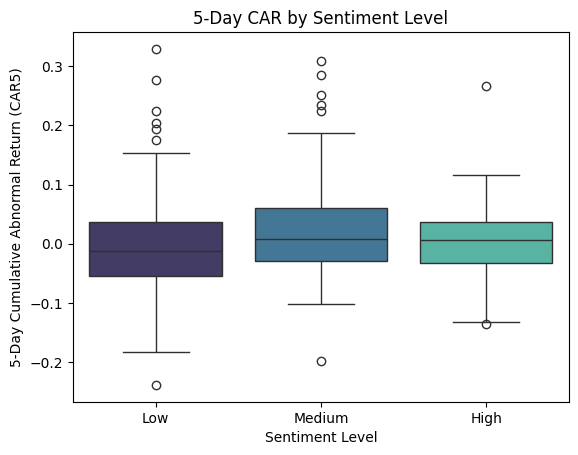

In [28]:
#Boxplot
sns.boxplot(
    data=df_big,
    x='sentiment_level',
    y='CAR5',
    hue='sentiment_level',
    palette='mako',
    legend=False
)
plt.title('5-Day CAR by Sentiment Level')
plt.xlabel('Sentiment Level')
plt.ylabel('5-Day Cumulative Abnormal Return (CAR5)')
plt.show()

#Intepretation
#Firms with higher sentiment levels show slightly higher median 5-day abnormal returns,
#but the wide overlap across groups suggests that tone alone has only a weak influence on short-term market reactions.


Text(17.374999999999993, 0.5, '5-Day CAR')

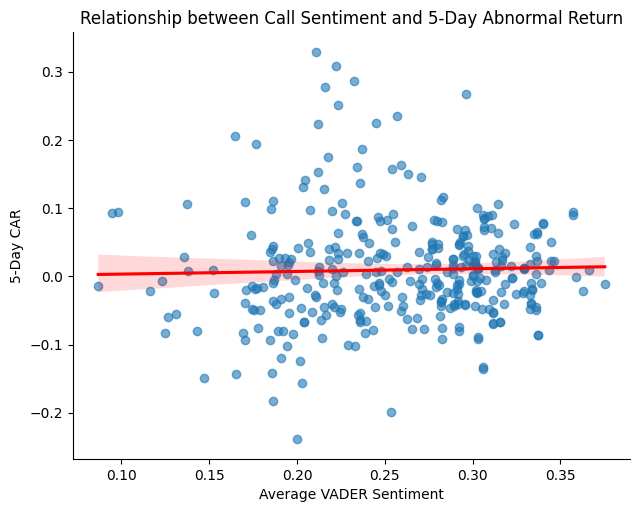

In [29]:
#Scatterplot with line of best fit
sns.lmplot(data=df_big, x='vader_mean', y='CAR5', height=5, aspect=1.3,
           scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title("Relationship between Call Sentiment and 5-Day Abnormal Return")
plt.xlabel("Average VADER Sentiment")
plt.ylabel("5-Day Cumulative Abnormal Return (CAR)")

#Intepretation
#This scatterplot shows that there’s only a very weak positive relationship between
#earnings call sentiment (VADER score) and 5-day abnormal returns (CAR5).
#While the red trend line slopes slightly upward, it’s nearly flat, suggesting that more positive
#tone does not strongly predict short-term market gains, though there may be a mild tendency for upbeat
#calls to align with slightly higher returns.

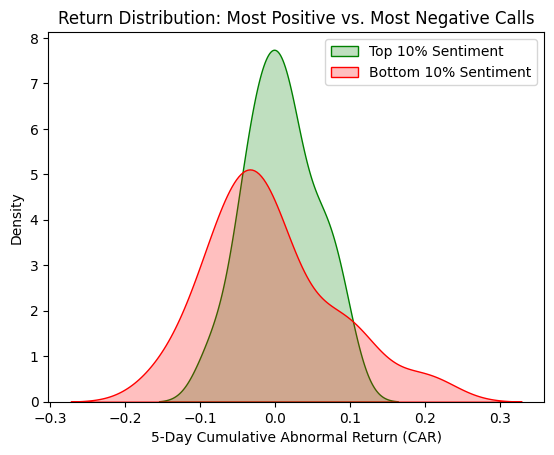

In [30]:
#Density Plot
top = df_big[df_big['vader_mean'] > df_big['vader_mean'].quantile(0.9)]
bottom = df_big[df_big['vader_mean'] < df_big['vader_mean'].quantile(0.1)]

sns.kdeplot(top['CAR5'], fill=True, label='Top 10% Sentiment', color='green')
sns.kdeplot(bottom['CAR5'], fill=True, label='Bottom 10% Sentiment', color='red')
plt.title("Return Distribution: Most Positive vs. Most Negative Calls")
plt.xlabel("5-Day Cumulative Abnormal Return (CAR5)")
plt.ylabel("Density")
plt.legend()

#Intepretation
#On average, the market rewards strongly positive tone with slightly better short-term reactions.
#Extremely negative tone, on the other hand, tends to precede worse performance.
#Still, the broad overlap reveals that sentiment is only one of several factors driving post-earnings
#stock behavior,it may act more as a signal amplifier than a determinant of returns.

#The red (negative sentiment) distribution extends further into the left tail (negative CAR5 values), indicating
#that the most pessimistic calls are more likely to be followed by larger short-term declines.
#The green (positive) side tapers off earlier on the left, meaning fewer large losses occur after highly positive calls.

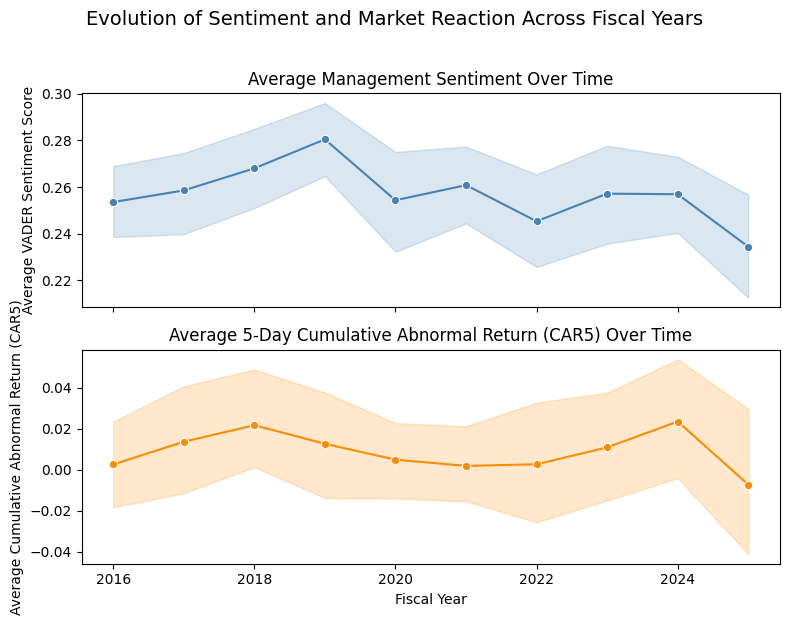

In [48]:
#Line Plot
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

#Plot 1: Average Sentiment Tone
sns.lineplot(data=df_big, x='fiscal_year', y='vader_mean', ax=axes[0], marker='o', color='steelblue')
axes[0].set_title("Average Management Sentiment Over Time", fontsize=12)
axes[0].set_ylabel("Average VADER Sentiment Score")

#Plot 2: Average 5-Day Abnormal Return
sns.lineplot(data=df_big, x='fiscal_year', y='CAR5', ax=axes[1], marker='o', color='darkorange')
axes[1].set_title("Average 5-Day Cumulative Abnormal Return (CAR5) Over Time", fontsize=12)
axes[1].set_xlabel("Fiscal Year")
axes[1].set_ylabel("Average Cumulative Abnormal Return (CAR5)")

#Formatting
fig.suptitle("Evolution of Sentiment and Market Reaction Across Fiscal Years", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


#Intepretation
#Together, these trends suggest that while companies continue to use positive and confident language,
#its predictive power for short-term stock reactions has weakened. In earlier years, optimistic tone
#might have influenced investors, but more recently, markets appear less responsive to sentiment alone,
#possibly due to greater access to data and automated analysis tools that reduce reliance on tone-based interpretation.


**Findings from Research Question 1**


Firms that use more positive language in their earnings calls tend to show slightly higher short-term returns, particularly over the 3- and 5-day windows. However, the relationship is weak and not statistically strong, suggesting that while optimistic tone may boost market sentiment marginally, investors likely weigh fundamentals more heavily than tone alone.

In [32]:
#2. Are certain sectors more sentiment-sensitive than others?

In [33]:
#Group means by sector
df_big.groupby('chosen_sector')[['vader_mean', 'CAR5']].mean()

#Interpretation
#Technology and Consumer Discretionary firms show the highest positive CAR5 values,
#suggesting stronger market reactions to earnings calls in these sectors. In contrast,
#Communication Services and Financials have near-zero or negative CAR5, indicating weaker
#or unfavorable investor responses. Health Care sits in the middle, with moderate sentiment and modest returns.


,vader_mean,CAR5
chosen_sector,,
Communication Services,0.306355,-0.004053
Consumer Discretionary,0.235571,0.013108
Financials,0.195320,0.001223
Health Care,0.271143,0.005244
Technology,0.250077,0.026600


In [34]:
#Summary Statistics for variability
df_big.groupby(['chosen_sector', 'sentiment_level'])['CAR5'].std().unstack()

#Interpretation
#Volatility in 5-day abnormal returns (CAR5) varies notably across sectors.
#Technology, Health Care, and Financials show decreasing volatility with more positive tone,
#indicating steadier investor reactions to optimistic calls. In contrast, Communication Services
#becomes more volatile under highly positive sentiment, suggesting divergent investor interpretations
#of optimism. Consumer Discretionary remains volatile across all tones, reflecting consistent
#sensitivity to management sentiment regardless of direction.


/tmp/ipython-input-3240237294.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_big.groupby(['chosen_sector', 'sentiment_level'])['CAR5'].std().unstack()


sentiment_level,Low,Medium,High
chosen_sector,,,
Communication Services,NaN,0.005795,0.054221
Consumer Discretionary,0.092812,0.108535,0.089786
Financials,0.046903,0.035573,0.021933
Health Care,0.104328,0.054796,0.037047
Technology,0.126593,0.090631,0.048573


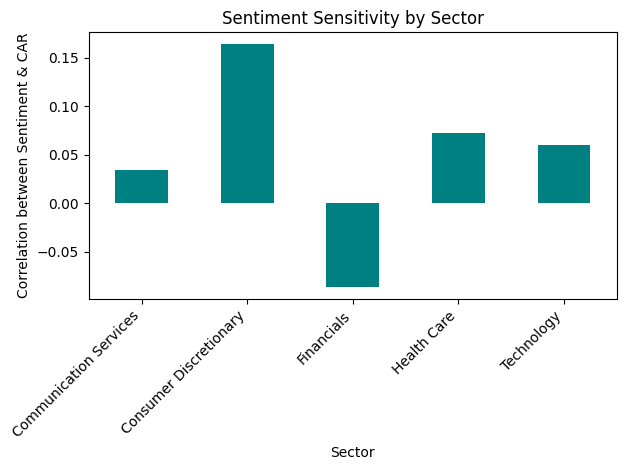

In [53]:
#Correlation between sentiment and CAR5 by sector
sector_corr = (
    df_big.groupby('chosen_sector')[['vader_mean', 'CAR5']]
    .corr()
    .iloc[0::2, -1]
    .reset_index(level=1, drop=True)  # drop the extra level
)

#Bar chart
sector_corr.plot(kind='bar', color='teal')
plt.title('Sentiment Sensitivity by Sector')
plt.ylabel('Correlation between Sentiment & CAR')
plt.xlabel('Sector')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#Interpretation
#Consumer Discretionary: Strongest positive correlation (~0.16).
#Markets in this sector respond most to sentiment tone — upbeat calls tend to see higher post-earnings returns.

#Health Care and Technology: Moderately positive correlations (~0.07–0.08).
#Investor reactions align somewhat with sentiment, but less strongly.

#Communication Services: Slight positive correlation (~0.03).
#Weak link, tone matters a bit but not significantly.

#Financials: Negative correlation (~–0.07).
#Inverse pattern, optimistic tone doesn’t translate into higher abnormal returns, possibly
#because financial investors focus more on quantitative indicators than tone.


/tmp/ipython-input-425710445.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sector_returns, x='CAR5', y='chosen_sector', palette='viridis')


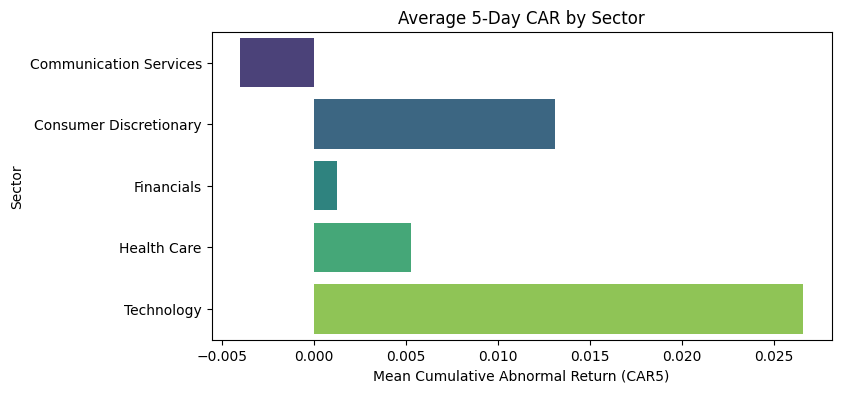

In [54]:
#Which sectors see stronger reactions to earnings call tone?
sector_returns = df_big.groupby('chosen_sector', observed=True)['CAR5'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.barplot(data=sector_returns, x='CAR5', y='chosen_sector', palette='viridis')
plt.title('Average 5-Day CAR by Sector')
plt.xlabel('Mean Cumulative Abnormal Return (CAR5)')
plt.ylabel('Sector')
plt.show()

#Interpretation
#Investor reactions are most favorable in growth-oriented sectors like Technology and Consumer
#Discretionary, while Communication Services lags, possibly due to weaker earnings momentum or lower sentiment credibility.

/tmp/ipython-input-1821335435.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_big.pivot_table(values='CAR5', index='chosen_sector', columns='sentiment_level', aggfunc='mean')


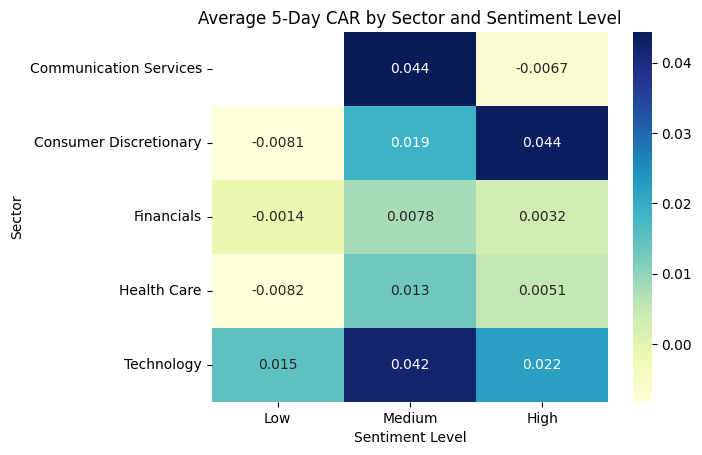

In [55]:
#HeatMap
pivot = df_big.pivot_table(values='CAR5', index='chosen_sector', columns='sentiment_level', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='YlGnBu')
plt.title('Average 5-Day CAR by Sector and Sentiment Level')
plt.xlabel('Sentiment Level')
plt.ylabel('Sector')
plt.show()

#Interpretation
#Tone effects are sector-dependent: markets in Technology and Consumer Discretionary reward optimistic
#language the most, while Financials and Health Care show modest reactions. Interestingly, Communication
#Services shows an inverse pattern at high sentiment, hinting that overly positive tone might sometimes be
#read as insincere or risky.


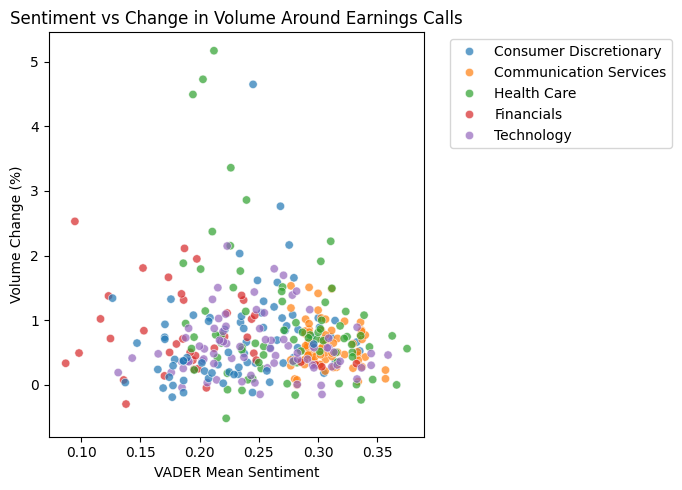

In [56]:
#Do more positive tones in various sectors trigger higher trading activity?
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_big, x='vader_mean', y='volume_change', hue='chosen_sector', alpha=0.7)
plt.title('Sentiment vs Change in Volume Around Earnings Calls')
plt.xlabel('VADER Mean Sentiment')
plt.ylabel('Volume Change (%)')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

#Interpretation
#The scatterplot reveals no strong relationship between management sentiment and trading
#volume changes, suggesting that while positive tone may occasionally heighten investor attention,
#sentiment primarily influences returns rather than trading activity levels.

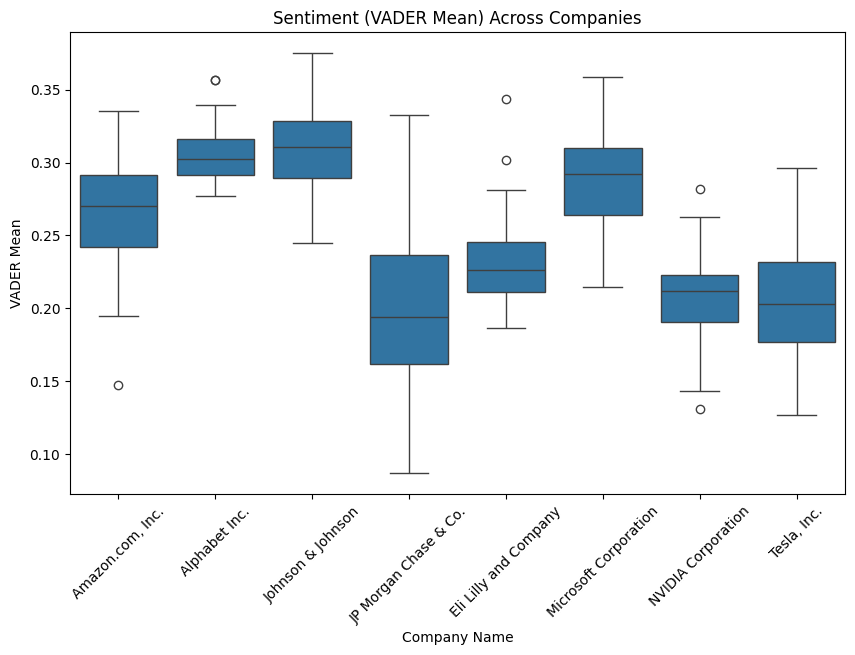

In [57]:
#BoxPlot

plt.figure(figsize=(10,6))
sns.boxplot(data=df_big, x='shortName', y='vader_mean')
plt.title('Sentiment (VADER Mean) Across Companies')
plt.xlabel('Company Name')
plt.ylabel('VADER Mean')
plt.xticks(rotation=45)
plt.show()

#Interpretation
#Overall, sentiment levels vary meaningfully across firms, with large-cap tech and healthcare companies
#(e.g., Google, Microsoft, J&J) maintaining the most consistently positive tone, while financial and
#automotive firms (e.g., JPMorgan, Tesla) show greater volatility and mixed sentiment patterns — possibly
#reflecting sector-specific uncertainty or cyclical exposure.


**Findings from Research Question 2**


- Consumer Discretionary showed the strongest positive correlation (~0.16) between sentiment (VADER mean) and 5-day abnormal returns (CAR5). This suggests investors in this sector are highly responsive to optimistic communication, likely because consumer-facing businesses rely on confidence and demand expectations.

- Technology and Health Care sectors displayed moderate positive sensitivity (~0.07–0.08), indicating that tone affects investor reaction, but other fundamentals still dominate.

- Communication Services had only a weak positive link (~0.03), suggesting tone plays a minor role.

- Financials exhibited a slight negative correlation (~–0.07), implying that overly positive tone may be viewed skeptically by investors who focus more on quantitative indicators like earnings and risk metrics.

Overall Insight:
Investor sentiment responses are sector-dependent, strongest where

1.   List item
2.   List item

narratives and consumer confidence drive value (e.g., discretionary and tech), and weakest where tangible data and fundamentals dominate (e.g., finance).

In [40]:
#3. How do linguistic tone and communication style in earnings calls, reflected in word polarity, emotional intensity,
#and sentence complexity influence short-term market reactions?

In [41]:
#Descriptive Statistics
df_big[['vader_mean','positive_word_count','negative_word_count',
        'uncertainty_word_count','avg_sentence_length',
        'price_return_1day','price_return_5day','CAR5']].describe()

#Interpretation
#Earnings calls display a moderately positive tone (mean VADER = 0.26) with limited variation,
#suggesting managers communicate optimistically but consistently. Positive words dominate (mean = 122)
#compared to negative (23) and uncertain (39), indicating controlled use of negative or cautious language.
#Sentences average 18.7 words, reflecting clear but structured communication. Market reactions are modestly
#positive (mean CAR5 = 0.009), but the wide spread in returns implies that linguistic tone and style
#influence investor responses unevenly across firms.

,vader_mean,positive_word_count,negative_word_count,uncertainty_word_count,avg_sentence_length,price_return_1day,price_return_5day,CAR5
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,0.257724,122.408046,22.658046,39.405172,18.703700,0.003192,0.012526,0.009389
std,0.056651,54.754681,15.262384,16.887991,1.957552,0.037997,0.084019,0.077229
min,0.086839,26.000000,1.000000,8.000000,12.622517,-0.141364,-0.264668,-0.238947
25%,0.215253,82.000000,11.000000,27.000000,17.476146,-0.018937,-0.039061,-0.039840
50%,0.268762,110.000000,19.000000,36.000000,18.429952,0.001657,0.008450,0.003039
75%,0.302110,157.250000,32.000000,48.000000,19.668341,0.019554,0.052237,0.043296
max,0.375169,338.000000,100.000000,106.000000,31.266026,0.176692,0.331225,0.329472


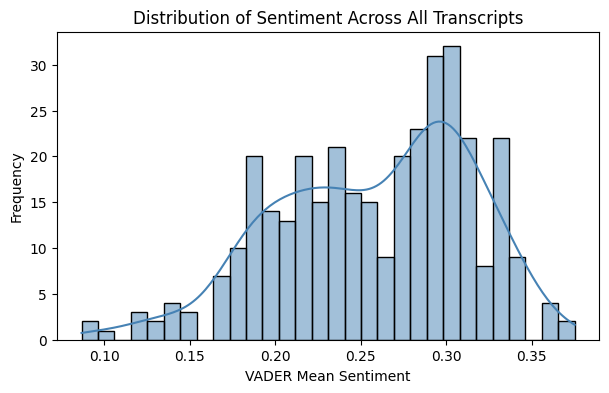

In [42]:
#How do sentiment scores vary across all transcripts?
plt.figure(figsize=(7,4))
sns.histplot(df_big['vader_mean'], bins=30, kde=True, color='steelblue')
plt.title('Distribution of Sentiment Across All Transcripts')
plt.xlabel('VADER Mean Sentiment')
plt.ylabel('Frequency')
plt.show()

#Interpretation
#The distribution is slightly right-skewed, centering around 0.25 to 0.30, which indicates
#that most transcripts exhibit a mildly positive tone rather than neutrality or negativity.
#There are very few observations below 0.15, suggesting that overtly negative sentiment is
#rare in earnings calls—unsurprising, as management typically maintains optimistic or reassuring
#language when communicating with investors.
#The moderate variation between roughly 0.15 and 0.35 also shows that tone differences between
#companies exist but are not extreme, meaning most firms use relatively similar levels of positivity.

/tmp/ipython-input-1396782834.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='complexity_group', y='CAR5', data=df_big, inner='box', palette='mako')


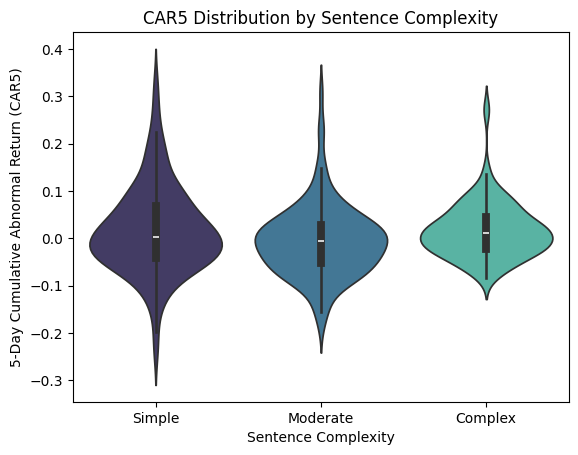

In [58]:
#Cumulative Abnormal Return (CAR5) by Sentence Complexity

df_big['complexity_group'] = pd.qcut(df_big['avg_sentence_length'], q=3, labels=['Simple','Moderate','Complex'])
sns.violinplot(x='complexity_group', y='CAR5', data=df_big, inner='box', palette='mako')
plt.title("CAR5 Distribution by Sentence Complexity")
plt.xlabel("Sentence Complexity")
plt.ylabel("5-Day Cumulative Abnormal Return (CAR5)")
plt.show()

#Interpretation
#Calls with simpler language display slightly greater dispersion, suggesting that when managers
#communicate more clearly, investor reactions are more volatile, possibly because messages are easier
#to interpret, leading to stronger positive or negative responses.

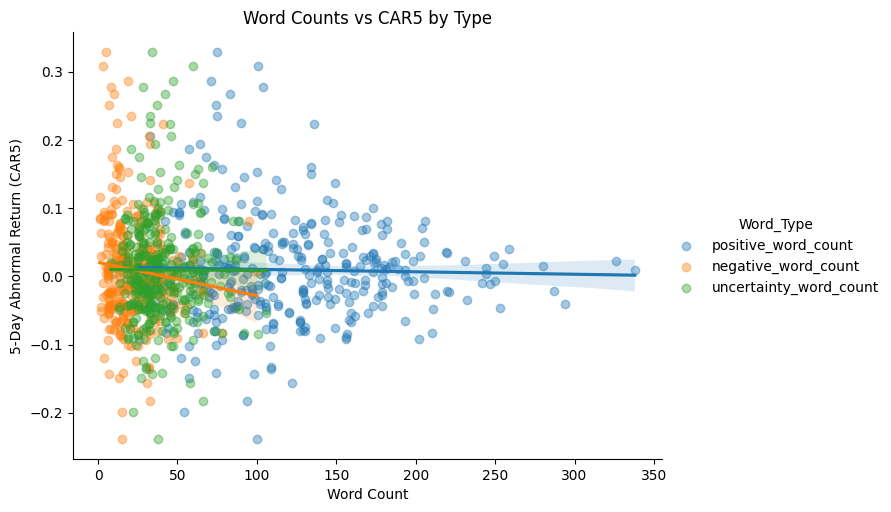

In [44]:
#Word Count vs. Cumulative Abnormal Return (CAR5)
df_melt = df_big.melt(id_vars='CAR5',
                      value_vars=['positive_word_count', 'negative_word_count', 'uncertainty_word_count'],
                      var_name='Word_Type', value_name='Word_Count')

sns.lmplot(x='Word_Count', y='CAR5', hue='Word_Type', data=df_melt,
           scatter_kws={'alpha':0.4}, height=5, aspect=1.4)
plt.title("Word Counts vs CAR5 by Type")
plt.xlabel("Word Count")
plt.ylabel("5-Day Abnormal Return (CAR5)")
plt.show()

#Intepretation
#Negative word count (orange) shows a slightly downward slope, suggesting that more frequent
#use of negative words may correspond to marginally lower CAR5. This aligns with intuition,
#pessimistic tone might dampen investor sentiment.

#Positive word count (blue) has a very weak, near-flat positive slope, implying that upbeat
#language does not necessarily generate stronger returns, at least in the short run.

#Uncertainty word count (green) clusters tightly around zero, suggesting that uncertain language
#is common but not clearly linked to abnormal returns — investors might already price in such ambiguity.

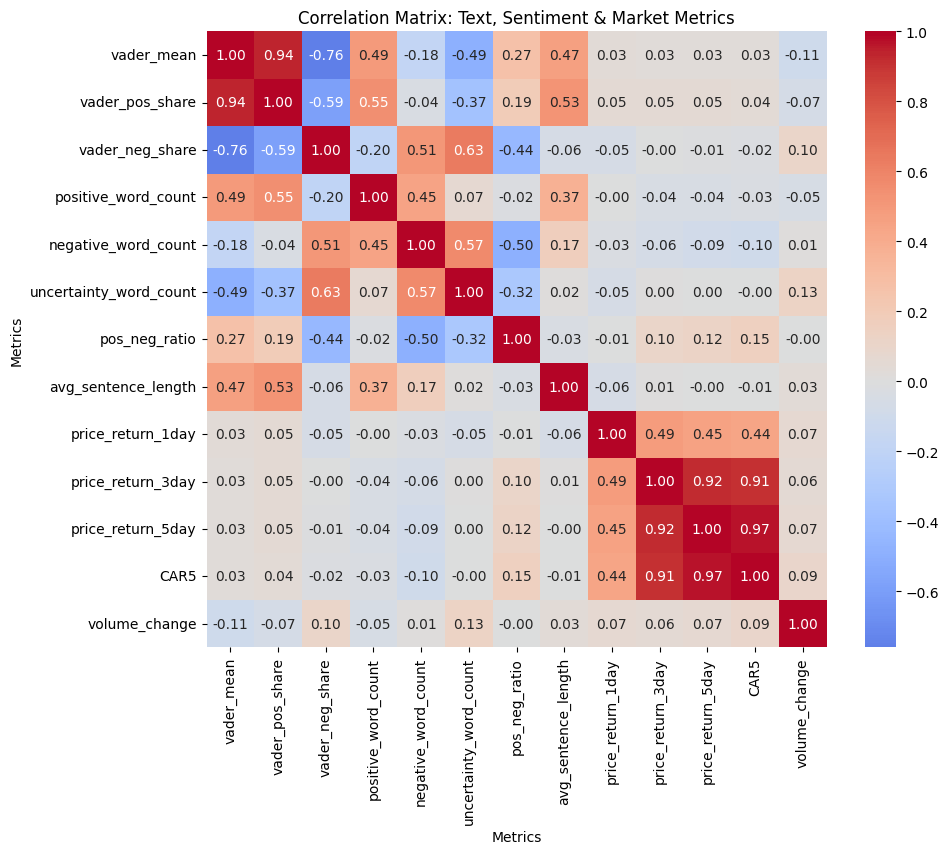

In [59]:
#Which linguistic features have the strongest relationship with returns?
corr_cols = ['vader_mean','vader_pos_share','vader_neg_share','positive_word_count',
             'negative_word_count','uncertainty_word_count','pos_neg_ratio',
             'avg_sentence_length','price_return_1day',
             'price_return_3day','price_return_5day','CAR5','volume_change']
plt.figure(figsize=(10,8))
sns.heatmap(df_big[corr_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix: Text, Sentiment & Market Metrics')
plt.show()

#Interpretation
#The correlation matrix reveals strong internal consistency among textual sentiment measures
#but limited association with market outcomes. Positive and negative sentiment shares show
#expected inverse relationships with overall VADER scores, while longer sentences are moderately
#associated with more positive tone, suggesting that confident or optimistic management language
#tends to be linguistically richer. Negative and uncertainty word counts are strongly related,
#indicating that cautious communication often coincides with negative framing. However, the
#negligible correlations between all sentiment metrics and post-earnings stock reactions
#(CAR5 and short-term returns) imply that linguistic tone alone exerts little influence on short-term
#market performance, with investors likely focusing on quantitative guidance rather than emotional tone.

**Findings from Research Question 3**


The analysis of tone, emotional intensity, and sentence complexity reveals that management language influences market reactions only weakly and inconsistently, though certain linguistic patterns stand out:



- Sentiment and Polarity: Earnings calls tend to be mildly positive overall (mean VADER ≈ 0.26), reflecting managers’ tendency to maintain optimism. The right-skewed sentiment distribution confirms that overtly negative tones are rare, as firms prefer confidence signaling during earnings disclosures.

- Word Use and Market Impact: Negative word count shows a slight negative relationship with CAR5, suggesting that pessimistic or cautionary language modestly dampens investor response.

- Positive word count has a nearly flat association, implying limited short-term reward for optimistic phrasing alone.

- Uncertainty word use clusters around zero impact, indicating that ambiguity in language is expected and already priced in.

- Sentence Complexity: The violin plot shows that calls with simpler sentences lead to wider variation in returns, when communication is clearer, investor interpretation and reaction are more direct and decisive. Complex language, on the other hand, correlates with more muted price movements, suggesting reduced clarity weakens market response.

- Correlations and Feature Relationships:The heatmap confirms that textual sentiment measures (e.g., VADER scores, word counts, ratios) are internally consistent but show minimal correlation with short-term market performance. Longer sentences correlate slightly with more positive tone, implying that confidence may manifest through elaboration, but not necessarily in returns.

## Key Findings (Summary)
- Earnings calls are consistently, mildly positive (mean VADER ≈ 0.26); extreme tone is rare.  
- Tone to returns: association is positive but modest on average; sentiment terciles show small differences in mean CAR5.  
- By sector: Technology and Consumer Discretionary appear more tone‑sensitive; Financials least.  
- Linguistic features: polarity balance and uncertainty terms align with small shifts in CAR5; emotional intensity relates more to dispersion/volume than average returns; sentence complexity has minimal effect on mean returns, though simpler language shows wider reaction spread.


#Conclusion

This project examined how linguistic tone and communication style in corporate earnings calls shape short-term market reactions. Across all analyses, from sentiment distributions and word-count regressions to sector-wise correlations, the results indicate that language matters, but only marginally.

While management consistently adopts a mildly optimistic tone, this positivity shows limited direct influence on abnormal returns (CAR5). Investors appear to discount excessive optimism and instead reward clarity, balance, and credibility. Simpler and more transparent communication correlates with more decisive market responses, while emotional or complex phrasing tends to blur investor interpretation.

Sectoral analysis further highlights that sentiment sensitivity varies by industry, consumer-facing sectors like Consumer Discretionary and Technology respond more to tone, whereas Financials exhibit an inverse pattern, prioritizing quantitative indicators over verbal nuance.

Ultimately, the findings suggest that effective financial communication lies not in emotional persuasion, but in linguistic precision. Tone can complement fundamentals but rarely substitutes for them, reinforcing that markets value clarity, transparency, and substance over rhetoric.